# Rubik's Cube Solver

## Dependencies

In [1]:
import cv2
import imutils
import pathlib
import numpy as np
from imutils import contours
from imutils import perspective
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

## Loading a sample

In [765]:
def load_image(path: pathlib.Path, eq: bool = False, verbose: bool = False) -> np.ndarray:
    img = cv2.imread(path)
    img = imutils.resize(img, width=240)
    if eq:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if verbose:
        plt.figure()
        plt.imshow(img)
    return img

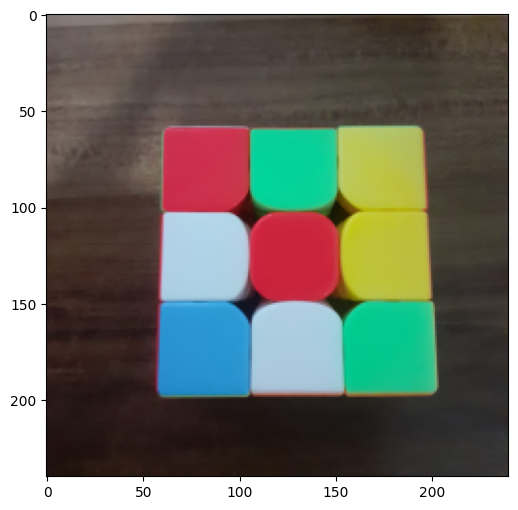

In [766]:
sample = load_image("data/6.png", eq=False, verbose=True)

In [767]:
def threshold_channel(channel):
    blurred = cv2.GaussianBlur(channel, (5, 5), 0)
    _, binarized = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binarized

In [768]:
def segment_colors(rgb_img: np.ndarray, boost: bool = False, verbose: bool = False):
    flattened = warped.reshape((-1, 3))
    flattened = np.float32(flattened)
    iters = 16
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iters, 0.1)
    _, labels, centers = cv2.kmeans(
        flattened, 9, None, criteria, iters, cv2.KMEANS_PP_CENTERS
    )
    centers = np.uint8(centers)
    labels = labels.flatten()
    flattened = centers[labels]
    segmented = flattened.reshape(warped.shape)
    if boost:
        segmented = cv2.convertScaleAbs(segmented, alpha=1.2, beta=0)

    if verbose:
        plt.figure()
        plt.imshow(segmented)

    return segmented

In [777]:
def fix_perspective(rgb_img: np.ndarray, verbose: bool = False):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    s = hsv_img[:, :, 1]
    v = hsv_img[:, :, 2]
    s_bin = threshold_channel(s)
    v_bin = threshold_channel(v)

    s_bin_compactness = np.sum(s_bin) / np.prod(s_bin.shape)
    v_bin_compactness = np.sum(v_bin) / np.prod(v_bin.shape)

    if s_bin_compactness < v_bin_compactness:
        binarized = s_bin
    else:
        binarized = v_bin

    binarized = cv2.morphologyEx(
        binarized, cv2.MORPH_OPEN, np.ones((7,7)), iterations=4
    )
    binarized = cv2.morphologyEx(
        binarized, cv2.MORPH_CLOSE, np.ones((5,5)), iterations=4
    )
    edges = imutils.auto_canny(binarized)
    cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    rect = cv2.minAreaRect(cnts[0])
    box = cv2.boxPoints(rect)
    pts_src = np.array(box, dtype=np.float32)
    origin_x, origin_y = box[0]
    width = rgb_img.shape[0]
    height = rgb_img.shape[1]
    pts_dst = np.array(
        [
            [0, 0],
            [width, 0],
            [width, height],
            [0, height],
        ],
        dtype=np.float32,
    )
    M, _ = cv2.findHomography(pts_src, pts_dst)
    fixed = cv2.warpPerspective(rgb_img, M, (width, height))

    if verbose:
        rgb_cnts = rgb_img.copy()
        # overlay box
        cv2.drawContours(rgb_cnts, cnts, -1, (0, 255, 0), 1)
        cv2.drawContours(rgb_cnts, [box.astype(np.int32)], -1, (0, 0, 255), 2)

        plt.figure()
        plt.subplot(131)
        plt.imshow(binarized, cmap="gray")
        plt.subplot(132)
        plt.imshow(rgb_cnts)
        plt.subplot(133)
        plt.imshow(fixed)
        plt.tight_layout()

    corrected = perspective.four_point_transform(rgb_img, box)
    return corrected

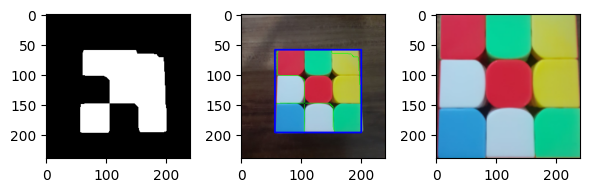

In [778]:
warped = fix_perspective(sample, verbose=True)

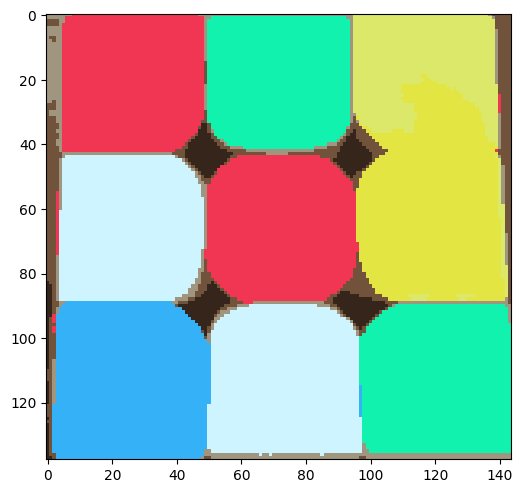

In [779]:
segmented = segment_colors(warped, boost=True, verbose=True)

In [788]:
def apply_morphology(channel: np.ndarray) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    channel = cv2.morphologyEx(channel, cv2.MORPH_OPEN, kernel, iterations=6)
    bg = cv2.dilate(channel, kernel, iterations=8)
    dst = cv2.distanceTransform(channel, cv2.DIST_L2, 5)
    _, fg = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
    fg = np.uint8(fg)
    return fg, bg

In [795]:
def process_channel(channel: np.ndarray, verbose: bool = False) -> np.ndarray:
    binarized = threshold_channel(channel)
    fg, bg = apply_morphology(binarized)

    if verbose:
        plt.figure()
        plt.subplot(131)
        plt.title("Binarized")
        plt.imshow(binarized, cmap="gray")
        plt.subplot(132)
        plt.title("Foreground")
        plt.imshow(fg, cmap="gray")
        plt.subplot(133)
        plt.title("Background")
        plt.imshow(bg, cmap="gray")
        plt.tight_layout()

    return fg, bg

In [796]:
def get_color_mask(
    rgb_img: np.ndarray, padding: int = 0, verbose: bool = False
) -> np.ndarray:
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    s = hsv_img[:, :, 1]
    v = hsv_img[:, :, 2]

    fg_s, bg_s = process_channel(s, verbose=True)
    fg_v, bg_v = process_channel(v, verbose=True)

    compactness_s = np.sum(fg_s) / np.prod(fg_s.shape)
    compactness_v = np.sum(fg_v) / np.prod(fg_v.shape)

    if compactness_s < compactness_v:
        channel = s
        fg = fg_s
        bg = bg_s
    else:
        channel = v
        fg = fg_v
        bg = bg_v

    mask = cv2.bitwise_not(cv2.subtract(bg, fg))

    if verbose:
        plt.figure()
        plt.subplot(131)
        plt.title("Channel")
        plt.imshow(channel, cmap="gray")
        plt.subplot(132)
        plt.title("Foreground")
        plt.imshow(fg, cmap="gray")
        plt.subplot(133)
        plt.title("Mask")
        plt.imshow(mask, cmap="gray")

    return mask

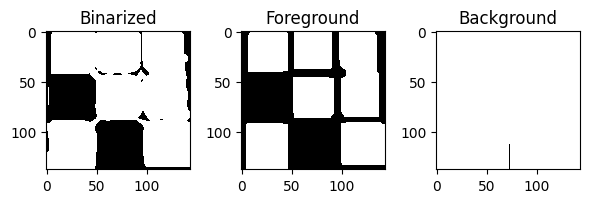

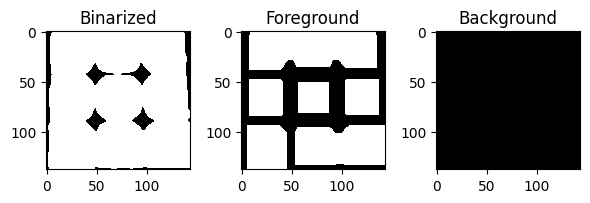

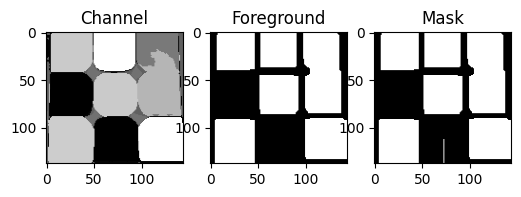

In [797]:
mask = get_color_mask(segmented, padding=10, verbose=True)

In [600]:
def get_cube(segmented: np.ndarray, mask: np.ndarray, w_size: int = 10, verbose: bool = False):
    edges = imutils.auto_canny(mask)
    cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts, _ = contours.sort_contours(cnts, method="top-to-bottom")

    if verbose:
        clone = segmented.copy()
        cv2.drawContours(clone, cnts, -1, (0, 255, 0), 1)
        plt.figure()
        plt.imshow(clone)

    cube = []
    row = []
    for i, c in enumerate(cnts[:9], 1):
        row.append(c)
        if i % 3 == 0:
            row_cnts, _ = contours.sort_contours(row, method="left-to-right")
            for c in row_cnts:
                (x_left, y_top), _, _ = cv2.minAreaRect(c)
                x_min = np.clip(x_left - w_size, 0, 255).astype(np.int32)
                x_max = np.clip(x_left + w_size, 0, 255).astype(np.int32)
                y_min = np.clip(y_top - w_size, 0, 255).astype(np.int32)
                y_max = np.clip(y_top + w_size, 0, 255).astype(np.int32)
                piece = segmented[y_min:y_max, x_min:x_max]
                cube.append(piece)
            row = []
    return cube

In [522]:
colors = {
    "blue": [(0,0,104), (0,255,0), (151,151,255)],
    "green": [(0, 104, 0), (0, 255, 0), (151, 202, 151)],
    "orange": [(104, 68, 0), (255, 165, 0), (255, 218, 151)],
    "red": [(104, 0, 0), (255, 0, 0), (255, 151, 151)],
    "white": [(204, 204, 204), (255, 255, 255), (255, 255, 255)],
    "yellow": [(104, 104, 0), (255, 255, 0), (255, 255, 151)],
}

colors = {name: np.array(color) for name, color in colors.items()}

In [523]:
def distance(a: np.ndarray, b: np.ndarray) -> float:
    return np.sqrt(np.sum((a - b) ** 2))

In [524]:
def color_distance(color: np.ndarray, reference, margin: int = 50) -> float:
    d_low = distance(color, np.clip(reference - margin, 0, 255))
    d_base = distance(color, reference)
    d_upper = distance(color, np.clip(reference + margin, 0, 255))
    return 3000 / (d_low + d_base + d_upper)

In [525]:
def classify_color(piece: np.ndarray, colors: dict, verbose: bool = False) -> str:
    scores = {}
    for name, (lower, base, upper) in colors.items():
        score_lower = color_distance(piece, lower)
        score_base = color_distance(piece, base)
        score_upper = color_distance(piece, upper)
        scores[name] = 0.3 * score_lower + 0.5 * score_base + 0.2 * score_upper
    best_color = max(scores, key=scores.get)
    if verbose:
        plt.figure()
        plt.imshow(piece)
        plt.title(f"{best_color}: {scores[best_color]:.2f}")
    return best_color

In [526]:
def get_face(rgb_image: np.ndarray, w_size: int = 10, verbose: bool = False) -> np.ndarray:
    warped = fix_perspective(rgb_image)
    segmented = segment_colors(warped, boost=True)
    mask = get_color_mask(segmented)
    cube = get_cube(segmented, mask, w_size=w_size, verbose=True)
    cube = np.array([classify_color(piece, colors, verbose=True) for piece in cube])
    cube = cube.reshape((3, 3))
    return cube

ValueError: cannot reshape array of size 6 into shape (3,3)

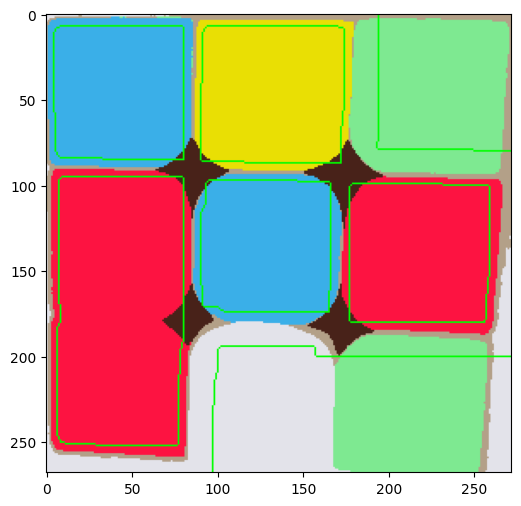

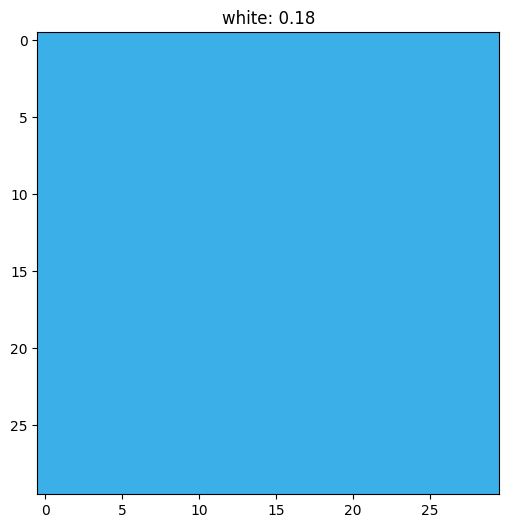

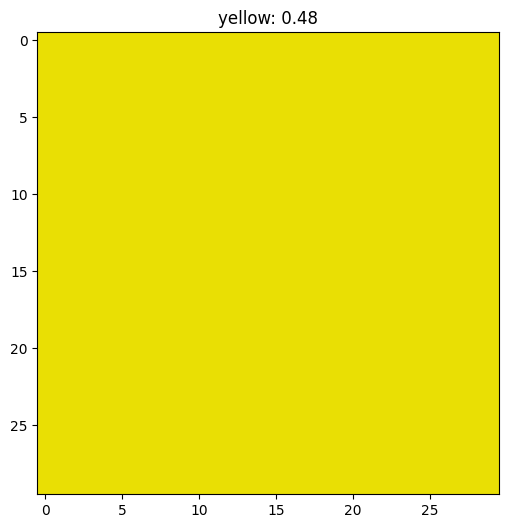

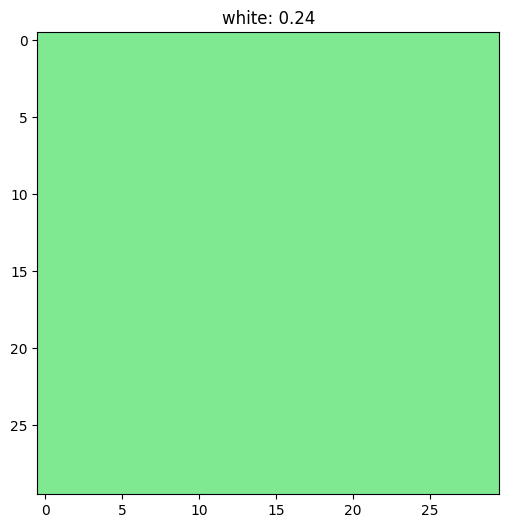

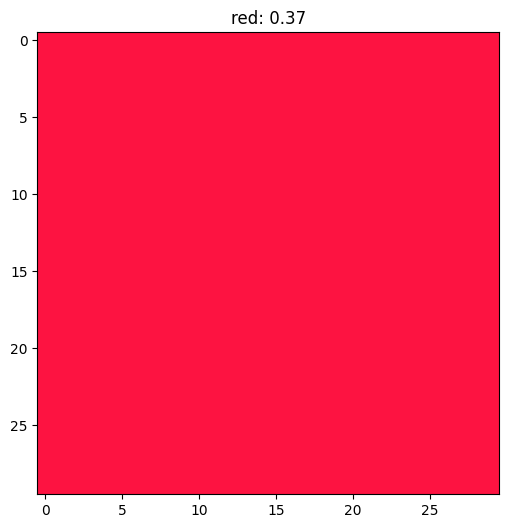

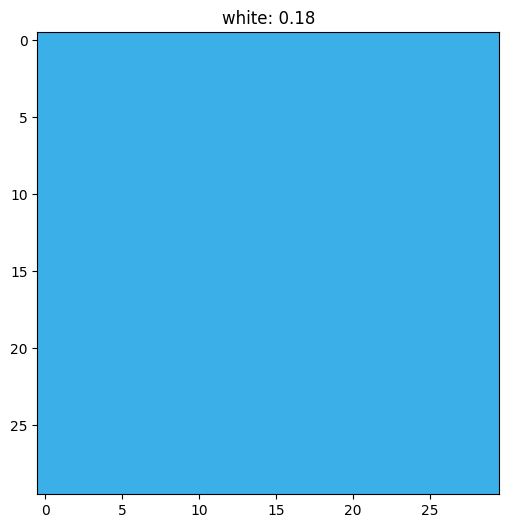

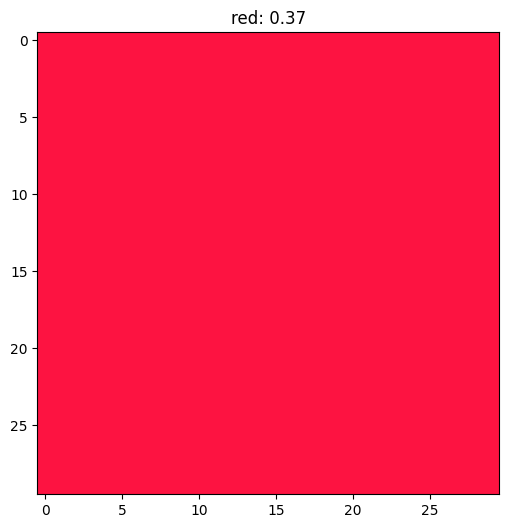

In [527]:
cube = get_face(sample, w_size=15)